In [1]:
import pandas as pd

import warnings
import os

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
warnings.filterwarnings('ignore')

**November 2018**

Jag fick idén att man borde se vilka kommuner som gjort flest/färst skatteförändringar av alla Sveriges kommuner de senaste åren. Med hjälp av data från SCB och från Kolada, samt i kontakt med SKL för att få fram var det skett skatteväxlingar mellan kommun/landsting, räknades detta ut. Anledningen till att vi behövde få tag på data över skatteväxlingar är eftersom en skattehöjning i en kommun kan bero på en överenskommelse med landstinget att skatteväxla. Det vill säga att kommunen ger upp eller tar över ett ansvarsområde som innefattar beskattning för finansiering. T ex att man tar över busstrafiken i kommunen från landstinget. En sådan skattehöjning är då inte att se som en reell sådan, då invånarnas plånbok inte påverkas. Det är bara en annan mottagare av pengarna. 

Nedan har skatteväxlingar kontrollerats och tagits bort från resultatet. Resultatet publicerades i nr 2 2019 i tidningen och [finns att läsa här på webben](https://www.dagenssamhalle.se/nyhet/lagskattekommuner-hojer-skatten-mest-25751). 

## Koladadata

In [3]:
df = pd.read_excel('data/kommunalskatt.xls').rename(columns={
    'Kommun/Landsting':'kommun'
})

In [4]:
df=df.iloc[:,1:]

In [5]:
df.columns

Index(['kommun', 'År', 'Visat Värde'], dtype='object')

In [6]:
df=df.pivot(index='kommun',columns='År',values='Visat Värde')

In [7]:
len(df.columns)

24

In [8]:
cols = [x for x in df.columns if x > 2007]

In [9]:
df=df[cols]

In [10]:
def value_checker(df,index,col):
    value = df.at[index,col]
    counter = 0
    for i in range(24):
        if value == df.at[index,col-1]:
            counter += 1
            col -= 1
        else:
            return counter
        

In [11]:
def num_tax_changes(df,index,col,num_years=24):
    value = df.at[index,col]
    ökning = 0
    minskning = 0
    for i in range(num_years):
        if value != df.at[index,col-1]:
            if value < df.at[index,col-1]:
                minskning += 1
            elif value > df.at[index,col-1]:
                ökning += 1
            else:
                continue
            value = df.at[index,col-1]
            col -= 1
        else:
            col -= 1
    return (ökning,minskning)
        

In [12]:
def skatteändringar(df,start_year=2018,num_years=23):
    results = []
    for kommun in df.reset_index().kommun.tolist():
        row = {}
        row['kommun'] = kommun
        #row['years_unchanged'] = value_checker(df,kommun,2018)
        row['num_changes'] = num_tax_changes(df,index=kommun,col=start_year,num_years=num_years)
        results.append(row)
    return pd.DataFrame(results)

In [13]:
years=df.columns.tolist()

In [14]:
years.sort(reverse=True)

In [15]:
ph = pd.DataFrame()
for year in years[:10]:
    ph[year] = skatteändringar(df,start_year=year,num_years=1).iloc[:,-1]

In [16]:
years=ph.columns.tolist()
years.sort()

In [17]:
ph=ph.loc[:,years]

In [18]:
ph['kommun'] = df.reset_index().kommun

In [19]:
ph = ph.set_index('kommun')

In [20]:
results_increase = ph.iloc[:,14:]
results_decrease = ph.iloc[:,14:]

In [21]:
for col in results_increase.columns:
    results_increase[col] = results_increase[col].apply(lambda x: x[0])
    results_decrease[col] = results_decrease[col].apply(lambda x: x[1])


In [22]:
frames = {'increase':results_increase.sum().reset_index().rename(columns={
    'index':'År',
    0:'Antal'
}),
          'decrease':results_decrease.sum().reset_index().rename(columns={
    'index':'År',
    0:'Antal'
})}

In [23]:
frames

{'increase': Empty DataFrame
 Columns: [År, Antal]
 Index: [], 'decrease': Empty DataFrame
 Columns: [År, Antal]
 Index: []}

## SCB

### Hämtning och grundtvätt av data

In [24]:
df=pd.read_excel('data/test.xlsx').reset_index(drop=True).rename(columns={
    'Skattesats, total kommunal':'totalt',
    'Skattesats till kommun':'kommunskatt',
    'Skattesats till landsting':'landstingsskatt'
})

In [25]:
df.kommun=df.kommun.ffill()

In [26]:
df.kommun=df.kommun.apply(lambda x: x[5:]).str.strip()

In [27]:
df.år=df.år.astype('int')

In [28]:
df.head()

,kommun,år,totalt,kommunskatt,landstingsskatt
0,Upplands Väsby,2000,29.90,19.58,10.32
1,Upplands Väsby,2001,29.90,19.58,10.32
2,Upplands Väsby,2002,29.90,19.58,10.32
3,Upplands Väsby,2003,31.20,19.58,11.62
4,Upplands Väsby,2004,31.85,19.58,12.27


In [29]:
#cols = [x for x in df.år.unique() if x > 2007]

In [30]:
#df=df.loc[df['år'].isin(cols)]

Lägg till län:

In [31]:
län = pd.read_excel('data/kommun_län.xlsx')

In [32]:
df = df.merge(län,on='kommun',how='left')

In [33]:
df=df.loc[df['län']!='Gotland']

In [34]:
df=df[['län','kommun','år','totalt','kommunskatt','landstingsskatt']]

### Beräkna jämförelse med året innan

In [35]:
def förändring(df,column):
    df[f'förändring_{column}'] = df[column] - df[column].shift(1)
    return df

In [36]:
for col in df.columns[-2:]:
    df = förändring(df,col)

In [37]:
df=df.loc[df['år']!=2000]

In [38]:
df.head()

,län,kommun,år,totalt,kommunskatt,landstingsskatt,förändring_kommunskatt,förändring_landstingsskatt
1,Stockholm,Upplands Väsby,2001,29.90,19.58,10.32,0.0,0.00
2,Stockholm,Upplands Väsby,2002,29.90,19.58,10.32,0.0,0.00
3,Stockholm,Upplands Väsby,2003,31.20,19.58,11.62,0.0,1.30
4,Stockholm,Upplands Väsby,2004,31.85,19.58,12.27,0.0,0.65
5,Stockholm,Upplands Väsby,2005,31.85,19.58,12.27,0.0,0.00


In [39]:
ph = df.copy()

### Skatteväxlingar

In [40]:
skatteväxling = pd.read_excel('data/skatteväxling_per_län.xlsx').rename(columns={'Skatteförändring skatteväxling':'län'})

In [41]:
skatteväxling=skatteväxling.melt(id_vars='län',var_name='år',value_name='skatteväxling')

In [42]:
len(skatteväxling.län.unique())

20

### Nollställ de kommuner där det skett skatteväxling

In [43]:
df = ph.copy()

In [44]:
skatteväxling.år = skatteväxling.år.astype('int')

In [45]:
skatteväxling.head()

,län,år,skatteväxling
0,Stockholm,2002,0.0
1,Uppsala,2002,0.0
2,Södermanland,2002,0.0
3,Östergötland,2002,0.0
4,Jönköping,2002,0.0


In [46]:
df = df.merge(skatteväxling,on=['län','år'],how='left')

In [47]:
df.columns

Index(['län', 'kommun', 'år', 'totalt', 'kommunskatt', 'landstingsskatt',
       'förändring_kommunskatt', 'förändring_landstingsskatt',
       'skatteväxling'],
      dtype='object')

In [48]:
df.shape

(5202, 9)

In [49]:
df.head()

,län,kommun,år,totalt,kommunskatt,landstingsskatt,förändring_kommunskatt,förändring_landstingsskatt,skatteväxling
0,Stockholm,Upplands Väsby,2001,29.90,19.58,10.32,0.0,0.00,NaN
1,Stockholm,Upplands Väsby,2002,29.90,19.58,10.32,0.0,0.00,0.0
2,Stockholm,Upplands Väsby,2003,31.20,19.58,11.62,0.0,1.30,0.0
3,Stockholm,Upplands Väsby,2004,31.85,19.58,12.27,0.0,0.65,0.0
4,Stockholm,Upplands Väsby,2005,31.85,19.58,12.27,0.0,0.00,0.0


In [50]:
import numpy as np

Först några funktioner som kommer utföra alla beräkningar grundat på vilka tal som finns i serierna (fanns problem med uträkningar med positiva/negativa tal som inte gick att få ihop):

In [51]:
def neg_negatives_calc(df,series,col):
    negs = df.loc[df[series]<0]
    negs['koll'] = 'neg_negatives_calc'
    rest = df.loc[df[series]>=0]
    negs['justerad_förändring'] = (negs[series] - negs[col]).round(2)
    df = pd.concat([negs,rest])
    return df

def neg_positives_calc(df,series,col):
    pos = df.loc[df[series]>0]
    pos['koll'] = 'neg_positives_calc'
    rest = df.loc[df[series]<=0]
    pos['justerad_förändring'] = (pos[series] + pos[col]).round(2)
    df = pd.concat([pos,rest])
    return df

def pos_negatives_calc(df,series,col):
    negs = df.loc[df[series]<0]
    negs['koll'] = 'pos_negatives_calc'
    rest = df.loc[df[series]>=0]
    negs['justerad_förändring'] = ((negs[series]) + negs[col]).round(2)
    df = pd.concat([negs,rest])
    return df

def pos_positives_calc(df,series,col):
    pos = df.loc[df[series]>0]
    pos['koll'] = 'pos_positives_calc'
    rest = df.loc[df[series]<=0]
    pos['justerad_förändring'] = (pos[series] + pos[col]).round(2)
    df = pd.concat([pos,rest])
    return df

def zero_negatives_calc(df,series,col):
    zeros = df.loc[df[series]==0]
    zeros['koll'] = 'zero_negatives_calc'
    rest = df.loc[df[series]!=0]
    zeros['justerad_förändring'] = (zeros[series] + zeros[col]).round(2)
    df = pd.concat([zeros,rest])
    return df

def zero_positives_calc(df,series,col):
    zeros = df.loc[df[series]==0]
    zeros['koll'] = 'zero_positives_calc'
    rest = df.loc[df[series]!=0]
    zeros['justerad_förändring'] = (zeros[series] - zeros[col]).round(2)
    df = pd.concat([zeros,rest])
    return df

In [52]:
def neutralisering(df,förändring,skatteväxling):
    """Huvudsaklig funktion som utför korrekt justering \
av kolumnen 'justerad_förändring'. Resultatet blir att \
kolumnen får alla korrekt usterade värden där skatteväxling \
är borträknat från ev höjningar/sänkningar."""
    
    df['koll'] = np.nan
    
    negatives = df.loc[df[skatteväxling]<0]
    
    for func in [neg_negatives_calc,neg_positives_calc]:
        negatives = func(negatives,förändring,skatteväxling)
    
    positives = df.loc[df[skatteväxling]>0]
    for func in [pos_negatives_calc,pos_positives_calc]:
        positives = func(positives,förändring,skatteväxling)
        
    zeros = pd.concat([negatives,positives])
    for func in [zero_negatives_calc,zero_positives_calc]:
        zeros = func(zeros,förändring,skatteväxling)
    
    neutral = df.loc[(df[skatteväxling]==0)]
    neutral['justerad_förändring'] = neutral[förändring]
    
    neutral = pd.concat([neutral,zeros])
    
    return neutral[['län','kommun','år','totalt','kommunskatt','förändring_kommunskatt','skatteväxling','justerad_förändring', 'koll']]

In [53]:
test = neutralisering(df,'förändring_kommunskatt','skatteväxling')

In [54]:
test = test.sort_values(['kommun','år'])

Nedan följer några kontrollräkningar:

In [55]:
test.loc[(test['justerad_förändring']!=0)&(test['förändring_kommunskatt']>0)&(test['skatteväxling']<0)]

,län,kommun,år,totalt,kommunskatt,förändring_kommunskatt,skatteväxling,justerad_förändring,koll
4836,Västerbotten,Dorotea,2013,34.20,23.90,1.00,-0.20,0.80,neg_positives_calc
1218,Jönköping,Eksjö,2013,33.07,22.41,0.84,-0.34,0.50,neg_positives_calc
1038,Jönköping,Gnosjö,2013,33.05,22.39,0.59,-0.34,0.25,neg_positives_calc
1074,Jönköping,Habo,2013,33.08,22.42,1.09,-0.34,0.75,neg_positives_calc
4260,Gävleborg,Hofors,2013,34.52,23.01,0.12,-0.22,-0.10,neg_positives_calc
1393,Kalmar,Högsby,2008,32.33,22.12,0.16,-0.26,-0.10,neg_positives_calc
4998,Norrbotten,Jokkmokk,2013,33.13,22.95,0.72,-0.22,0.50,neg_positives_calc
87,Stockholm,Järfälla,2016,31.23,19.15,0.17,-0.02,0.15,neg_positives_calc
1003,Östergötland,Mjölby,2014,32.60,21.93,1.20,-0.25,0.95,neg_positives_calc
4296,Gävleborg,Nordanstig,2013,34.12,22.61,0.47,-0.22,0.25,neg_positives_calc


### Resultat

In [56]:
df = test[['kommun','år','justerad_förändring']]

In [57]:
df.loc[df['justerad_förändring']>0,'förändring'] = 'Skattehöjningar'
df.loc[df['justerad_förändring']<0,'förändring'] = 'Skattesänkningar'

In [58]:
df = df.dropna()

In [59]:
df['antal'] = 1

In [60]:
df = df.groupby(['år','förändring']).sum().reset_index().drop('justerad_förändring',axis=1)

In [61]:
os.makedirs('res')

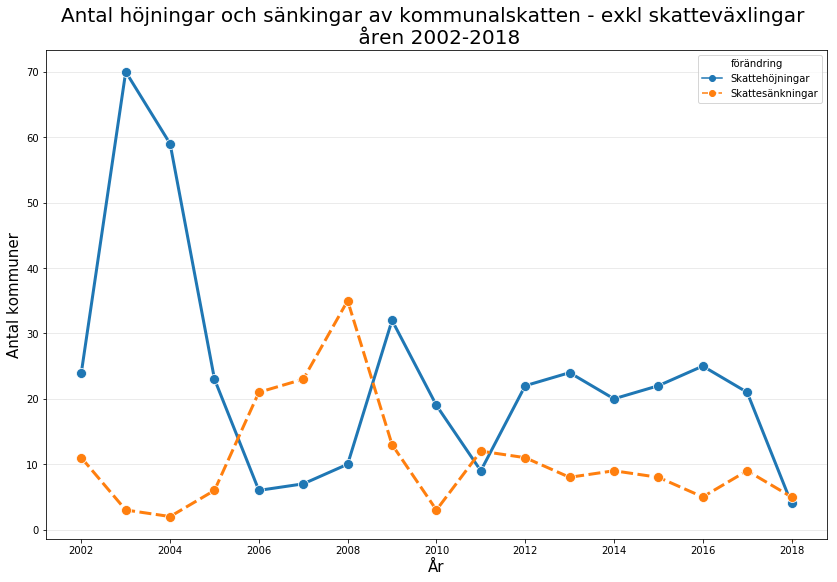

In [62]:
fig, ax = plt.subplots(figsize=(14,9))
sns.lineplot(x='år',y='antal',data=df,hue='förändring',style='förändring',markers=['o','o'],ax=ax,lw=3,markersize=10)
plt.grid(True,axis='y',alpha=0.3)
plt.title('Antal höjningar och sänkingar av kommunalskatten \
- exkl skatteväxlingar \n åren 2002-2018',
          fontsize=20)
plt.xlabel('År',fontsize=15)
plt.ylabel('Antal kommuner',fontsize=15)
plt.savefig('res/skatteförändringar_02-18.png',dpi=200)

In [63]:
test.pivot_table(index=['län','kommun'],columns='år',values=['totalt','kommunskatt','förändring_kommunskatt','skatteväxling','justerad_förändring']).reset_index().to_excel('res/totaltabell.xlsx')

In [64]:
df.to_excel('res/överblick_skatteförändringar.xlsx',index=False)


**BONUS**

Måns fick idén att vi borde kolla ifall de kommuner som hade högst skatt 2002 också hade höjt skatten med mest (bortjusterad skatteväxling) under perioden. Nedan följer en sådan beräkning. Notera att en fjärdedel av alla kommuner 2002 är 72 då varken Gotland eller Knivsta är med.

In [65]:
288/4

72.0

In [66]:
test.head()

,län,kommun,år,totalt,kommunskatt,förändring_kommunskatt,skatteväxling,justerad_förändring,koll
2593,Västra Götaland,Ale,2002,32.25,22.0,0.0,0.0,0.0,NaN
2594,Västra Götaland,Ale,2003,32.25,22.0,0.0,0.0,0.0,NaN
2595,Västra Götaland,Ale,2004,32.25,22.0,0.0,0.0,0.0,NaN
2596,Västra Götaland,Ale,2005,32.45,22.0,0.0,0.0,0.0,NaN
2597,Västra Götaland,Ale,2006,32.45,22.0,0.0,0.0,0.0,NaN


In [67]:
lägst = test.loc[test['år']==2002].sort_values('kommunskatt').iloc[1:].kommun.head(72).tolist()
högst = test.loc[test['år']==2002].sort_values('kommunskatt').iloc[1:].kommun.tail(72).tolist()

In [68]:
tmp = test.pivot_table(index=['län','kommun'],columns='år',values='justerad_förändring').reset_index()#.sum(axis=1)
tmp['res'] = tmp.sum(axis=1)
tmp = tmp[['kommun','res']]

In [69]:
tmp.loc[tmp['kommun'].isin(högst)].res.sum()

20.450000000000017

In [70]:
tmp.loc[tmp['kommun'].isin(lägst)].res.sum()

48.280000000000015

Med andra ord: de kommuner som har hade högst skatt 2002 har sedan högt skatten betydligt mindre än de som hade lägst skatt samma år!

In [71]:
df.head()

,år,förändring,antal
0,2002,Skattehöjningar,24
1,2002,Skattesänkningar,11
2,2003,Skattehöjningar,70
3,2003,Skattesänkningar,3
4,2004,Skattehöjningar,59


In [72]:
höjning = df.loc[df['förändring']=="Skattehöjningar"].drop('förändring',axis=1)
sänkning = df.loc[df['förändring']=="Skattesänkningar"].drop('förändring',axis=1)

Jämfört med tidigare uträkning:

In [73]:
höjning

,år,antal
0,2002,24
2,2003,70
4,2004,59
6,2005,23
8,2006,6
10,2007,7
12,2008,10
14,2009,32
16,2010,19
18,2011,9


In [74]:
sänkning=sänkning.år.value_counts().reset_index().rename(columns={'index':'år','år':'antal'}).sort_values('år')

**Antalet skatteökningar/-minskningar de senaste fem åren**

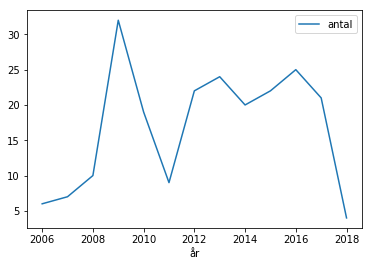

In [75]:
höjning.iloc[4:].set_index('år').plot()

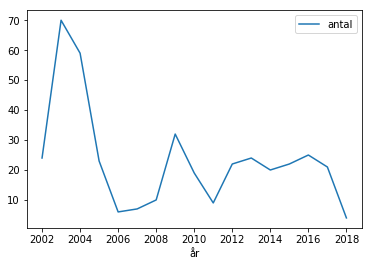

In [76]:
höjning.set_index('år').plot()

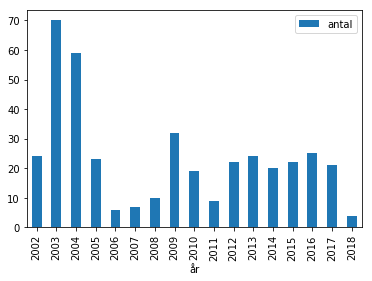

In [77]:
höjning.set_index('år').plot(kind='bar')

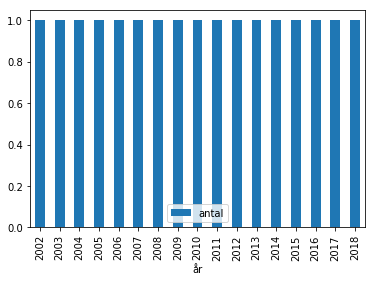

In [78]:
sänkning.set_index('år').plot(kind='bar')